In [18]:
import wrf
from netCDF4 import Dataset
from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
import os
import numpy as np
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

In [2]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'
filename = "wrfout_d02_2024-06-24_00_00_00"

In [3]:
# open data
ncfile = Dataset(os.path.join(file_path,filename))

In [4]:
# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

In [12]:
# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

In [13]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)
lons = np.where(lons < 0, lons + 360, lons) # convert the west longitude value to east

# Get the map projection information
cart_proj = get_cartopy(ht_500)

In [14]:
# Resample the data to reduce the number of barbs
scale = 25
lons = to_np(lons[::scale, ::scale])
lats = to_np(lats[::scale, ::scale])
wspd_500 = to_np(wspd_500[::scale, ::scale])
u_500 = to_np(u_500[::scale, ::scale])
v_500 = to_np(v_500[::scale, ::scale])
ht_500 = to_np(ht_500[::scale, ::scale])

In [15]:
# Make flip barb array
flip_barb = lats < 0
flip_barb

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  T

In [19]:
# Make colormaps
# Define the color list and levels for the contour plot
colorlist = ["#eff8fd", "#ccf0fe", "#9cdbfc", "#acffa7", "#7ede78", "#e6e675", "#fecb00", "#ff7d4b", "#e5270d", "#be0000", "#990000", "#7f00a0", "#ff647f"]
levels = [0, 5, 10, 15, 20, 25, 34, 48, 64, 80, 100, 120]

# Create a custom colormap and normalization
cmap = mcolors.LinearSegmentedColormap.from_list("", colorlist)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
cmap.set_over(colorlist[-1])
cmap.set_under(colorlist[0])

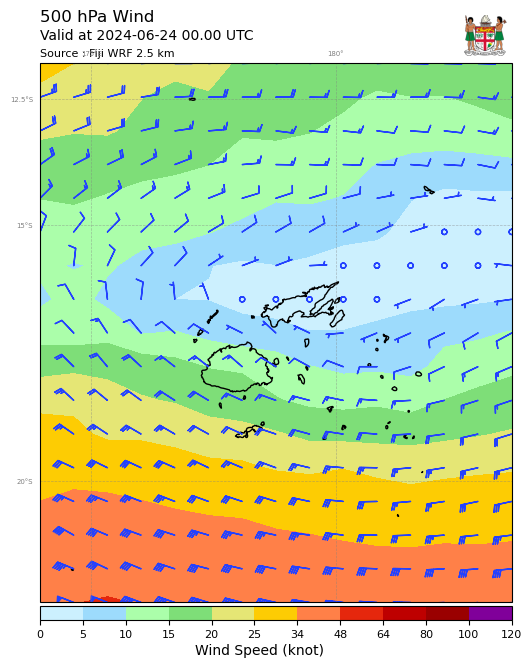

In [39]:
# Initiate the figure
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': cart_proj})

# Plot wind barbs
ax.barbs(lons, lats, u_500, v_500, length=5, barbcolor='#2341ff', flip_barb= flip_barb, transform=ccrs.PlateCarree(), zorder=2)

# Plot the 500 hPa wind speed
wspd_contours = ax.contourf(lons, lats, wspd_500, levels=levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# add colorbar
pos = ax.get_position() # get the original position
cbaxes = fig.add_axes([pos.x0, pos.y0 - 0.025, pos.x1 - pos.x0, 0.02])  # colorbar axes position left,bottom,width,height
plt.colorbar(wspd_contours, cax=cbaxes, orientation='horizontal', ticks=levels, extend="both", cmap=cmap)
cbaxes.tick_params(labelsize=8)

# add colorbar text
cbar_text = 'Wind Speed (knot)'
cbpos = cbaxes.get_position()
ax.text(x=0.5, y=cbpos.y0 - 0.05, s=cbar_text, size=10, ha="center", transform=fig.transFigure)

# Add title and time text
title_text = '500 hPa Wind'
time_text = 'Valid at 2024-06-24 00.00 UTC'
model_text = 'Source : Fiji WRF 2.5 km'

ax.set_title(title_text, x=pos.x0, y=pos.y1 + 0.06, pad=25, fontsize=12,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.035, s=time_text,transform=fig.transFigure, size=10, ha="left")
ax.text(x=pos.x0, y=pos.y1 + 0.01, s = model_text, transform=fig.transFigure, size=8, ha="left")

# Add logo
lgaxes = fig.add_axes([pos.x1 - 0.05, pos.y1 + 0.01, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/data/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.bottom_labels = False
gl.top_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}

# Set specific values for the gridlines
gl.xlocator = FixedLocator([165, 170, 175, 180, -175, -170, -165, -160, -155])
gl.ylocator = FixedLocator([-35, -30, -25, -20, -15, -12.5, -10, -7.5, -5])